In [51]:
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification,TrainingArguments,Trainer, pipeline
import evaluate
import torch
import numpy as np
import boto3
import os

In [22]:
df = pd.read_csv("https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/master/twitter_disaster_tweets.csv",usecols =["text","target"])
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,text,target
0,Typhoon Soudelor taking dead aim at Taiwan htt...,1
1,@accionempresa ChinaÛªs stock market crash th...,0
2,The f$&amp;@ing things I do for #GISHWHES Just...,0
3,VICTORINOX SWISS ARMY DATE WOMEN'S RUBBER MOP ...,1
4,@MisfitRarity misfit got bombed,0


In [23]:
# check for null values
df.isnull().sum()

text      0
target    0
dtype: int64

<Axes: >

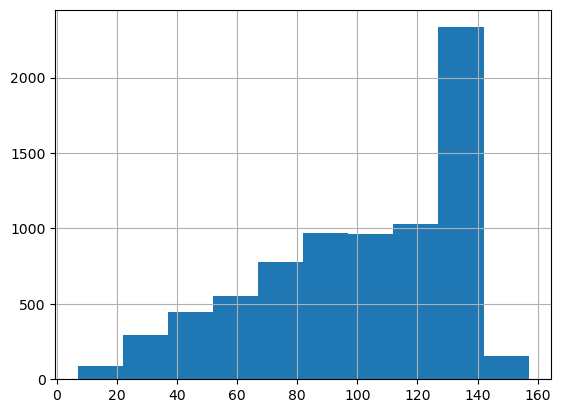

In [24]:
# get idea on text length variation
df['text'].str.len().hist()

In [25]:
# count the different targets
df['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [26]:
df = df.rename(columns={'target':'label'})

In [27]:
dataset = Dataset.from_pandas(df)
dataset = dataset.train_test_split(test_size=0.3)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 5329
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2284
    })
})

In [29]:
model_ckpt = "huawei-noah/TinyBERT_General_4L_312D"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt,use_fast=True)

In [30]:
def tokenize(batch):
    return tokenizer(batch['text'],padding=True,truncation=True,max_length=100)

dataset = dataset.map(tokenize)
dataset

Map:   0%|          | 0/5329 [00:00<?, ? examples/s]

Map:   0%|          | 0/2284 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5329
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2284
    })
})

In [32]:
accuracy = evaluate.load('accuracy')
def compute_metrics(eval_pred):
    predictions,lables = eval_pred
    predictions = np.argmax(predictions,axis=1)
    return accuracy.compute(predictions=predictions,references=lables)

In [36]:
label2id = {'general':0,'disaster': 1}
id2label = {0:'general',1:'disaster'}
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,num_labels=2,label2id=label2id,id2label=id2label)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
args = TrainingArguments(
    output_dir = 'train_dir',
    overwrite_output_dir=True,
    num_train_epochs=5,
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    eval_strategy='epoch'
)

In [42]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer  # instead of tokenizer=tokenizer
)

C:\Users\91963\AppData\Local\Temp\ipykernel_2244\627057421.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [43]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.488593,0.820490
2,No log,0.565126,0.798599
3,0.225200,0.519097,0.819615
4,0.225200,0.573183,0.804291
5,0.225200,0.557192,0.806480


TrainOutput(global_step=835, training_loss=0.21330870668331306, metrics={'train_runtime': 36.3968, 'train_samples_per_second': 732.07, 'train_steps_per_second': 22.942, 'total_flos': 43316623282548.0, 'train_loss': 0.21330870668331306, 'epoch': 5.0})

In [45]:
trainer.evaluate()

{'eval_loss': 0.5571922063827515,
 'eval_accuracy': 0.8064798598949212,
 'eval_runtime': 1.3006,
 'eval_samples_per_second': 1756.091,
 'eval_steps_per_second': 55.358,
 'epoch': 5.0}

In [46]:
trainer.save_model('tinybert-disaster-tweet')

In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
classifier = pipeline(
    'text-classification',
    'tinybert-disaster-tweet',
    device=device
)

Device set to use cuda


In [52]:
data = ['There is a fire in the building', 'I am happy today', 'I am sad today', 
          'I am not feeling well','There is a flood in the city, go to higher ground']

classifier(data)

[{'label': 'disaster', 'score': 0.9896134734153748},
 {'label': 'general', 'score': 0.9803370833396912},
 {'label': 'general', 'score': 0.9368066787719727},
 {'label': 'general', 'score': 0.97268146276474},
 {'label': 'disaster', 'score': 0.9910573959350586}]

In [50]:
s3 = boto3.client('s3')

In [53]:
BUCKET_NAME = "mlops-kgptalkie-faraz"

In [58]:
def upload_directory(local_directory,s3_prefix):
    for root, dirs, files in os.walk(local_directory):
        for file in files:
            file_path = os.path.join(root,file)
            rel_path = os.path.relpath(file_path,local_directory)
            s3_key = os.path.join(s3_prefix,rel_path).replace("\\","/")

            s3.upload_file(file_path,BUCKET_NAME,s3_key)

In [59]:
upload_directory('tinybert-disaster-tweet', 'ml-models/tinybert-disaster-tweet')